In [1]:
#define all relevant functions
import numpy as np
import pandas as pd
from scipy.fft import fftn, ifftn, fftshift
import re

import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.patches as mpatches

import numpy as np
import matplotlib.pyplot as plt
import os
import sys
#from scipy.spatial import ConvexHull
from scipy.spatial import Voronoi, voronoi_plot_2d
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import matplotlib.colors as mcolors

def lighten_color(color, factor=0.5):
    """Lighten the given color by a specified factor (0 = same, 1 = white)."""
    rgb = np.array(mcolors.to_rgb(color))
    return mcolors.to_rgba(rgb + (1 - rgb) * factor, alpha=0.5) 

In [2]:
def read_data(file_name):
    """Reads and processes data from a given file, correctly handling filenames with 'ffX'."""
    data = []
    
    with open(file_name, 'r') as f:
        for line in f:
            l = line.split()
            
            if len(l) != 4:
                continue  # Skip lines that do not match expected format
            
            try:
                # Extract the filename and split into parts
                file_parts = l[0].split("/")[-1].split("_")

                # Remove any "ffX" component
                file_parts = [part for part in file_parts if not (part.startswith("ff") and part[2:].isdigit())]

                # Extract only the LAST 4 elements (since the earlier ones are not needed)
                U = float(file_parts[-4])   # Extracts U parameter
                J = float(file_parts[-3])   # Extracts J parameter
                nk = int(file_parts[-2])    # Extracts nk number points
                nkf = int(file_parts[-1].split(".")[0])  # Extracts nkf number points

                Tc = l[1]  # Tc value
                phase = float(l[2])  # Dominant phase
                
                # Extract time in seconds
                time_parts = l[3].split("m")
                seconds = float(time_parts[0]) * 60 + float(time_parts[1].split("s")[0])
                
                # Store data as a LIST (not dictionary)
                final_data = [U, J, nk, nkf, Tc, phase, seconds]
                data.append(final_data)
            
            except (ValueError, IndexError) as e:
                print(f"Skipping line due to error: {line.strip()} - {e}")
    
    return data


In [3]:
def chemical_potential_to_doping(mu):
    mu_half_filling = 0
    k_B = 8.617e-5  #eV/K
    T = 300 #K
    
    n = 1 / (1 + np.exp((mu - mu_half_filling) / (k_B * T)))  # Example Fermi-Dirac function
    return 1 - n  



#relies on me setting the temperature for either near the phase transition or the temperature being roomt temperature 




In [4]:

import matplotlib.patches as mpatches



def plot_U_J_Voronoi_single(inputnames,models):
    # print(inputname,outputname,"PYTHON",os.getcwd())
    data = read_data(inputnames)
    # Triangular grid
    kb_ev = 8.6173303e-5 #eV
    x = []  #stores Us
    y = []  #stores Js
    groundstate = []
    points = []
    z = []
    doping = []
    for d in data:
        x.append(d[0])
        y.append(d[1])
        points.append([d[1],d[0]])  #U,J vector
        groundstate.append(d[4])  #Stores GS
        z.append((d[5])/kb_ev)  #stores Tc
        #doping.append(chemical_potential_to_doping(d[1]))


    #convert ground_State to numbers
    groundstate_num = []
    for i in range(len(groundstate)):
        if groundstate[i] == "FL":
            groundstate_num.append(0)
        elif groundstate[i] == "SC":
            groundstate_num.append(1)
        elif groundstate[i] == "SDW":
            groundstate_num.append(2)
        elif groundstate[i] == "CDW":
            groundstate_num.append(3)
        else:
            groundstate_num.append(-1)


    color_map = {
        "SC": "#A7C7E7",
        "CDW": "#FFB347",
        "FL": "black",
        "SDW": "#B0E57C"
    }

    max_U = max(y)
    min_U = min(y)
    max_J = max(x)
    min_J = min(x)

# Add in boundaries
    bs = 2

    for i in np.linspace(min_J - bs, max_J + bs, 201):
        points.append([i, min_U -bs])
        groundstate.append("Empty")
        groundstate_num.append(-1)

    for i in np.linspace(min_U -bs, max_U +bs, 201):
        points.append([min_J - bs, i])
        groundstate.append("Empty")
        groundstate_num.append(-1)

    for i in np.linspace(min_J -bs, max_J +bs, 201):
        points.append([i, max_U + bs])
        groundstate.append("Empty")
        groundstate_num.append(-1)

    for i in np.linspace(min_U -bs, max_U +bs, 201):
        points.append([max_J + 1, bs])
        groundstate.append("Empty")
        groundstate_num.append(-1)

    points = np.array(points)
    categories = np.array(groundstate_num)

# Compute Voronoi diagram
    vor = Voronoi(points)

    fig, ax = plt.subplots(figsize=(8, 6))

# Plot points with category colors
    for i in range(len(x)):
        colour = color_map.get(groundstate[i], "white")
        ax.scatter(y[i], x[i], c=colour, s=20, marker="x")

# **Fill Voronoi regions with lighter colors**
    patches = []
    for i, region in enumerate(vor.regions):
        if not -1 in region and len(region) > 0:  # Ignore open regions
            polygon_vertices = [vor.vertices[j] for j in region]
            polygon_vertices = [p for p in polygon_vertices if min_J - bs <= p[0] <= max_J + bs and min_U - bs <= p[1] <= max_U + bs]

            if len(polygon_vertices) > 0:

        # Find closest point to this region
                region_center = np.mean(polygon_vertices, axis=0)
                closest_idx = np.argmin(np.linalg.norm(points - region_center, axis=1))
                region_type = groundstate[closest_idx]  # Assign color based on closest classified point

                color = color_map.get(region_type, "white")  # Get marker color
                lighter_color = lighten_color(color, factor=0.6)  # Make it lighter

                polygon = Polygon(polygon_vertices, closed=True, edgecolor='none', facecolor=lighter_color)
                patches.append(polygon)

# Add filled regions to the plot
    p = PatchCollection(patches, match_original=True)
    ax.add_collection(p)

# Plot Voronoi edges (black)
    #for ridge in vor.ridge_vertices:
     #   if -1 not in ridge:  # Ignore infinite lines
      #      ridge_points = vor.vertices[ridge]
       #     ax.plot(ridge_points[:, 0], ridge_points[:, 1], 'black', linewidth=1)

    legend_patches = [mpatches.Patch(color=color, label=phase) for phase, color in color_map.items() if phase != "Empty"]

# Add the legend to the plot
    ax.legend(handles=legend_patches, title=" Phase", loc="upper right", fontsize=10)

    ax.set_ylabel("U (eV)")
    ax.set_xlabel(r"$\mu$ (eV)")
    #ax.set_title(f"{model}")
    ax.grid()

    plt.show()

    

    







In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from scipy.spatial import Voronoi
import matplotlib.patches as mpatches

def lighten_color(color, factor=0.6):
    """Lightens the given color by the specified factor."""
    import matplotlib.colors as mcolors
    rgb = mcolors.to_rgb(color)
    return mcolors.to_hex([min(1, c * factor) for c in rgb])

def plot_U_J_Voronoi(inputnames, models ):

    nplots = len(inputnames)

    fig, axs = plt.subplots(1, nplots, figsize=(20, 5))
    #fig.suptitle("Phase diagram for the 1NNN Hubbard model", fontsize = 35)



    for index, inputname in enumerate(inputnames):
        model = models[index]
        data = read_data(inputname)
        kb_ev = 8.6173303e-5  # eV
        x = []  # stores Js
        y = []  # stores Us
        groundstate = []
        points = []
        z = []
    
    # Read the data (swap x and y assignments)
        for d in data:
            x.append(d[1])  # Now x is J
            y.append(d[0])  # Now y is U
            points.append([d[1], d[0]])  # J, U vector (swapped)
            groundstate.append(d[4])  # Ground state phase
            z.append((d[5]) / kb_ev)  # Tc in eV
    
    # Convert ground_state to numerical values
        groundstate_num = []
        for state in groundstate:
            if state == "FL":
                groundstate_num.append(0)
            elif state == "SC":
                groundstate_num.append(1)
            elif state == "SDW":
                groundstate_num.append(2)
            elif state == "CDW":
                groundstate_num.append(3)
            else:
                groundstate_num.append(-1)

        color_map = {
            "SC": 'blue',
            "CDW": 'orange',
            "FL": "black",
            "SDW": "green",
            "Empty": "white"
        }

        max_U = max(y)
        min_U = min(y)
        max_J = max(x)
        min_J = min(x)

    # Add boundary points explicitly to fill the space
        bs = 0.5  # Boundary size

    # Add points on boundaries to close off the Voronoi diagram
        for i in np.linspace(min_J - bs, max_J + bs, 201):
            points.append([i, min_U - bs])
            groundstate.append("Empty")
            groundstate_num.append(-1)

        for i in np.linspace(min_U - bs, max_U + bs, 201):
            points.append([min_J - bs, i])
            groundstate.append("Empty")
            groundstate_num.append(-1)

        for i in np.linspace(min_J - bs, max_J + bs, 201):
            points.append([i, max_U + bs])
            groundstate.append("Empty")
            groundstate_num.append(-1)

        for i in np.linspace(min_U - bs, max_U + bs, 201):
            points.append([max_J + bs, i])
            groundstate.append("Empty")
            groundstate_num.append(-1)

        points = np.array(points)
        categories = np.array(groundstate_num)

    # Compute Voronoi diagram
        vor = Voronoi(points)

        

    # **Fill Voronoi regions with lighter colors**
        patches = []
        for i, region in enumerate(vor.regions):
            if not -1 in region and len(region) > 0:  # Ignore open regions
                polygon_vertices = [vor.vertices[j] for j in region]
                polygon_vertices = [p for p in polygon_vertices if min_J - bs <= p[0] <= max_J + bs and min_U - bs <= p[1] <= max_U + bs]

                if len(polygon_vertices) > 0:
                # Find closest point to this region
                    region_center = np.mean(polygon_vertices, axis=0)
                    closest_idx = np.argmin(np.linalg.norm(points - region_center, axis=1))
                    region_type = groundstate[closest_idx]  # Assign color based on closest classified point

                    color = color_map.get(region_type, "white")  # Get marker color
                    lighter_color = lighten_color(color, factor=0.6)  # Make it lighter

                    polygon = Polygon(polygon_vertices, closed=True, edgecolor='none', facecolor=lighter_color, alpha=0.5)  # Use alpha for transparency
                    patches.append(polygon)

    # Add filled regions to the plot
        p = PatchCollection(patches, match_original=True)
        axs[index].add_collection(p)

    # Plot points with category colors (on top of Voronoi regions)
        for i in range(len(x)):
            colour = color_map.get(groundstate[i], "white")
            axs[index].scatter(x[i], y[i], c=colour, s=30, marker="x", zorder=5)  # Scatter points on top

    # **Remove Voronoi boundary lines**: No black lines will be drawn here.

    # Add square grid with steps of 1
        axs[index].set_xticks(np.arange(min_J, max_J + 1, 1))  # X axis ticks (μ)
        axs[index].set_yticks(np.arange(min_U, max_U + 1, 1))  # Y axis ticks (U)
        axs[index].tick_params(axis='x', labelsize=16)
        axs[index].tick_params(axis='y', labelsize=16)
        axs[index].grid(True, which='both', axis='both', color='grey', linestyle='-', linewidth=1)
    

    # Legend
        legend_patches = [mpatches.Patch(color=color, label=phase) for phase, color in color_map.items() if phase != "Empty"]

    # Add the legend to the plot
         # axs[3].legend(handles=legend_patches, title="Phase", loc="upper right", fontsize=16)

        axs[0].set_ylabel("U (eV)", fontsize = 20)
        axs[index].set_xlabel(r"$\mu$ (eV)", fontsize = 20)
        axs[index].set_title(f"{model}", fontsize = 29)
        axs[index].set_ylim(min_U -0.2, max_U +0.2)
        axs[index].set_xlim(min_J-0.2, max_J+0.2)

        plt.tick_params(axis='both', labelsize=16) 
    plt.savefig(f"{models}.png")
    plt.show()


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from scipy.spatial import Voronoi
import matplotlib.patches as mpatches

def lighten_color(color, factor=0.6):
    """Lightens the given color by the specified factor."""
    import matplotlib.colors as mcolors
    rgb = mcolors.to_rgb(color)
    return mcolors.to_hex([min(1, c * factor) for c in rgb])

def plot_U_J_Voronoi_single(inputnames, models ):

   

    fig, ax = plt.subplots(figsize=(6, 8))
    #fig.suptitle("Phase diagram for the 1NNN Hubbard model", fontsize = 35)



    
        
    data = read_data(inputnames)
    kb_ev = 8.6173303e-5  # eV
    x = []  # stores Js
    y = []  # stores Us
    groundstate = []
    points = []
    z = []
    
    # Read the data (swap x and y assignments)
    for d in data:
        x.append(d[1])  # Now x is J
        y.append(d[0])  # Now y is U
        points.append([d[1], d[0]])  # J, U vector (swapped)
        groundstate.append(d[4])  # Ground state phase
        z.append((d[5]) / kb_ev)  # Tc in eV
    
    # Convert ground_state to numerical values
    groundstate_num = []
    for state in groundstate:
        if state == "FL":
            groundstate_num.append(0)
        elif state == "SC":
            groundstate_num.append(1)
        elif state == "SDW":
            groundstate_num.append(2)
        elif state == "CDW":
            groundstate_num.append(3)
        else:
            groundstate_num.append(-1)

    color_map = {
        "SC": 'blue',
        "CDW": 'orange',
        "FL": "black",
        "SDW": "green",
        "Empty": "white"
    }

    max_U = max(y)
    min_U = min(y)
    max_J = max(x)
    min_J = min(x)

    # Add boundary points explicitly to fill the space
    bs = 0.5  # Boundary size

    # Add points on boundaries to close off the Voronoi diagram
    for i in np.linspace(min_J - bs, max_J + bs, 201):
        points.append([i, min_U - bs])
        groundstate.append("Empty")
        groundstate_num.append(-1)

    for i in np.linspace(min_U - bs, max_U + bs, 201):
        points.append([min_J - bs, i])
        groundstate.append("Empty")
        groundstate_num.append(-1)

    for i in np.linspace(min_J - bs, max_J + bs, 201):
        points.append([i, max_U + bs])
        groundstate.append("Empty")
        groundstate_num.append(-1)

    for i in np.linspace(min_U - bs, max_U + bs, 201):
        points.append([max_J + bs, i])
        groundstate.append("Empty")
        groundstate_num.append(-1)

    points = np.array(points)
    categories = np.array(groundstate_num)

    # Compute Voronoi diagram
    vor = Voronoi(points)

        

    # **Fill Voronoi regions with lighter colors**
    patches = []
    for i, region in enumerate(vor.regions):
        if not -1 in region and len(region) > 0:  # Ignore open regions
            polygon_vertices = [vor.vertices[j] for j in region]
            polygon_vertices = [p for p in polygon_vertices if min_J - bs <= p[0] <= max_J + bs and min_U - bs <= p[1] <= max_U + bs]

            if len(polygon_vertices) > 0:
                # Find closest point to this region
                region_center = np.mean(polygon_vertices, axis=0)
                closest_idx = np.argmin(np.linalg.norm(points - region_center, axis=1))
                region_type = groundstate[closest_idx]  # Assign color based on closest classified point

                color = color_map.get(region_type, "white")  # Get marker color
                lighter_color = lighten_color(color, factor=0.6)  # Make it lighter

                polygon = Polygon(polygon_vertices, closed=True, edgecolor='none', facecolor=lighter_color, alpha=0.5)  # Use alpha for transparency
                patches.append(polygon)

    # Add filled regions to the plot
    p = PatchCollection(patches, match_original=True)
    ax.add_collection(p)

    # Plot points with category colors (on top of Voronoi regions)
    for i in range(len(x)):
        colour = color_map.get(groundstate[i], "white")
        ax.scatter(x[i], y[i], c=colour, s=30, marker="x", zorder=5)  # Scatter points on top

    # **Remove Voronoi boundary lines**: No black lines will be drawn here.

    # Add square grid with steps of 1
    ax.set_xticks(np.arange(min_J, max_J + 1, 1))  # X axis ticks (μ)
    ax.set_yticks(np.arange(min_U, max_U + 1, 1))  # Y axis ticks (U)
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
    ax.grid(True, which='both', axis='both', color='grey', linestyle='-', linewidth=1)
    

    # Legend
    legend_patches = [mpatches.Patch(color=color, label=phase) for phase, color in color_map.items() if phase != "Empty"]

    # Add the legend to the plot
         # axs[3].legend(handles=legend_patches, title="Phase", loc="upper right", fontsize=16)
    ax.legend(fontsize = 18)
    ax.set_ylabel("U (eV)", fontsize = 20)
    ax.set_xlabel(r"$\mu$ (eV)", fontsize = 20)
    #ax.set_title(f"{model}", fontsize = 29)
    ax.set_ylim(min_U -0.2, max_U +0.2)
    ax.set_xlim(min_J-0.2, max_J+0.2)

    plt.tick_params(axis='both', labelsize=16) 
    plt.savefig(f"{models}.png")
    plt.show()


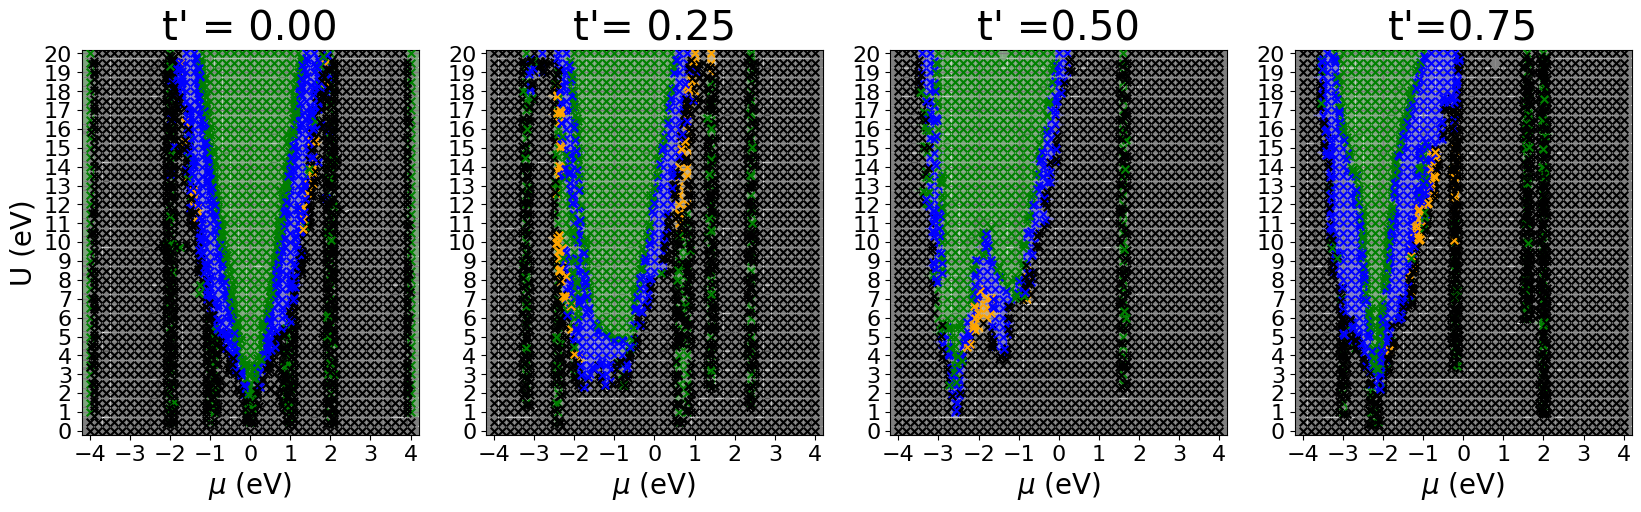

In [9]:
inputnames = ["1NN_20_5_ff4_PhaseDiagram.log", "1NNN_0p25_20_5_ff4_PhaseDiagram.log", "1NNN_0p5_20_5_ff4_PhaseDiagram.log","1NNN_0p75_20_5_ff4_PhaseDiagram.log"]
models =["t' = 0.00", "t'= 0.25", "t' =0.50", "t'=0.75"]

plot_U_J_Voronoi(inputnames, models)

/tmp/ipykernel_9211/2724198191.py:143: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(fontsize = 18)


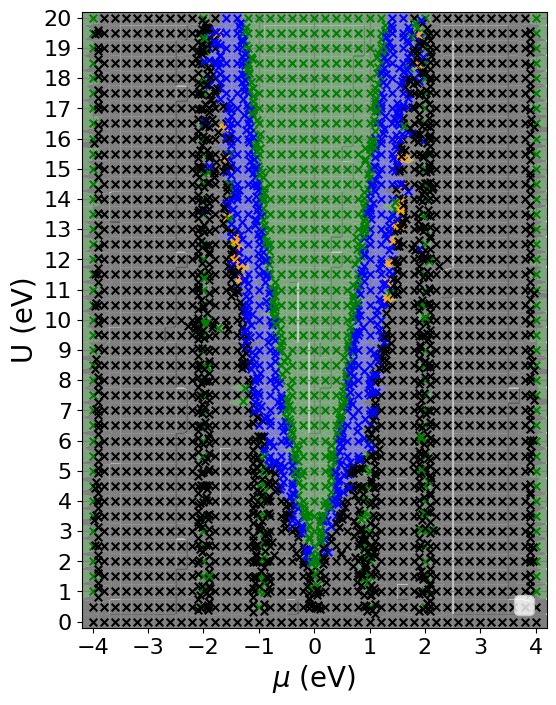

In [16]:
plot_U_J_Voronoi_single("1NN_20_5_ff4_PhaseDiagram.log"," 1NNpd")


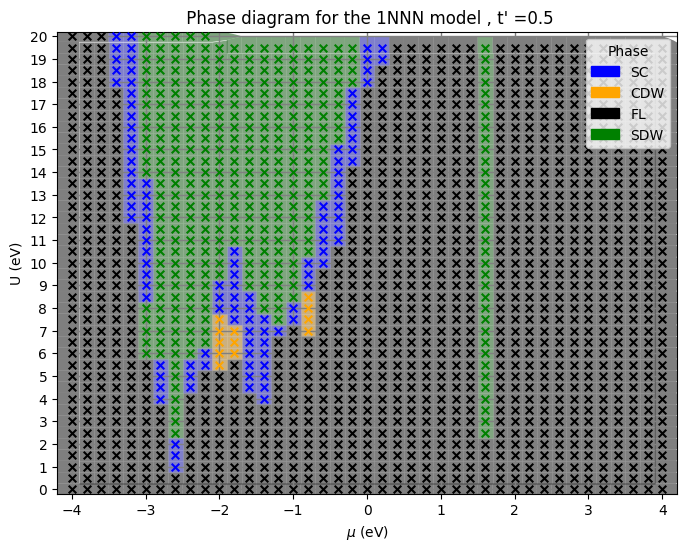

In [82]:
plot_U_J_Voronoi("1NNN_0p5_20_5_ff4_PhaseDiagram.log"," Phase diagram for the 1NNN model , t' =0.5")

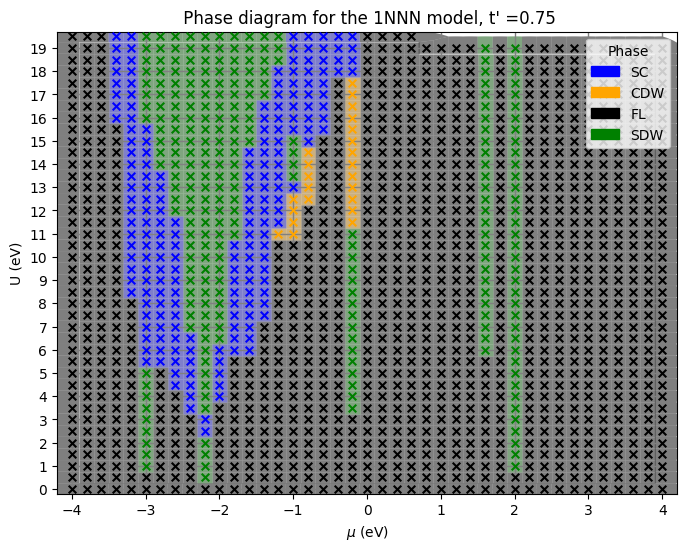

In [83]:
plot_U_J_Voronoi("1NNN_0p75_20_5_ff4_PhaseDiagram.log"," Phase diagram for the 1NNN model, t' =0.75")

In [25]:
import matplotlib.patches as mpatches
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from scipy.spatial import Voronoi, voronoi_plot_2d
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import matplotlib.colors as mcolors
from scipy.interpolate import griddata

def plot_U_J_Tc(inputname, model):
    data = read_data(inputname)
    kb_ev = 8.6173303e-5  # eV
    
    x, y, points, z = [], [], [], []
    for d in data:
        y.append(d[0])
        x.append(d[1])
        points.append([d[0], d[1]])  # U, J vector
        z.append((d[5]))  # Stores Tc
    
    max_U, min_U = max(x), min(x)
    max_J, min_J = max(y), min(y)
    
    # Generate grid for interpolation
    grid_x, grid_y = np.mgrid[min_U:max_U:200j, min_J:max_J:200j]
    grid_z = griddata((x, y), z, (grid_x, grid_y), method='cubic')
    
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Plot interpolated background
    contour = ax.imshow(grid_z.T, extent=(min_U, max_U, min_J, max_J), origin='lower', cmap='plasma', alpha=0.6, aspect='auto')
    cbar = plt.colorbar(contour, ax=ax)
    cbar.set_label("Tc Magnitude eV")
    
    # Scatter plot with colormap based on Tc magnitude
    scatter = ax.scatter(x, y, c=z, cmap='plasma', s=50, marker="x", edgecolors='k')
    
    # Compute Voronoi diagram
    points = np.array(points)
    vor = Voronoi(points)
    
    
    
    ax.set_xlabel(r"$\mu$ (eV)")
    ax.set_ylabel("U (eV)")
    ax.set_title(f"{model}")
    ax.grid()
    #plt.savefig(f"{model}.png")
    plt.show()


/tmp/ipykernel_6124/2554616597.py:38: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  scatter = ax.scatter(x, y, c=z, cmap='plasma', s=50, marker="x", edgecolors='k')


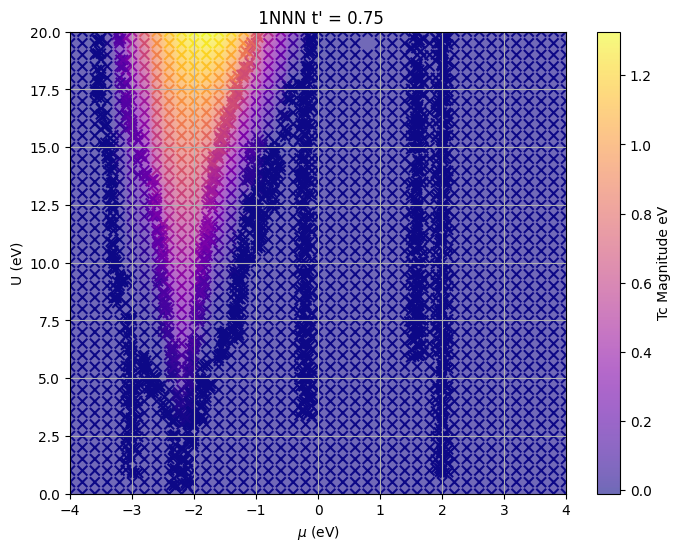

In [26]:
plot_U_J_Tc("1NNN_0p75_20_5_ff4_PhaseDiagram.log"," 1NNN t' = 0.75")

/tmp/ipykernel_6124/2554616597.py:38: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  scatter = ax.scatter(x, y, c=z, cmap='plasma', s=50, marker="x", edgecolors='k')


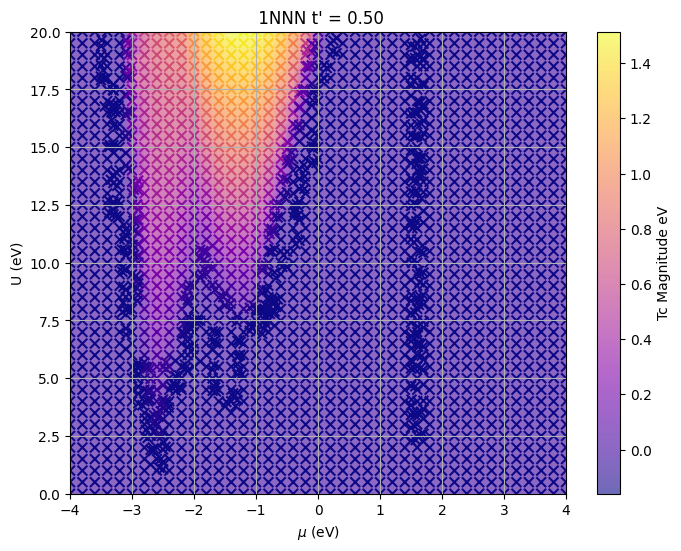

In [27]:
plot_U_J_Tc("1NNN_0p5_20_5_ff4_PhaseDiagram.log"," 1NNN t' = 0.50")

/tmp/ipykernel_6124/2554616597.py:38: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  scatter = ax.scatter(x, y, c=z, cmap='plasma', s=50, marker="x", edgecolors='k')


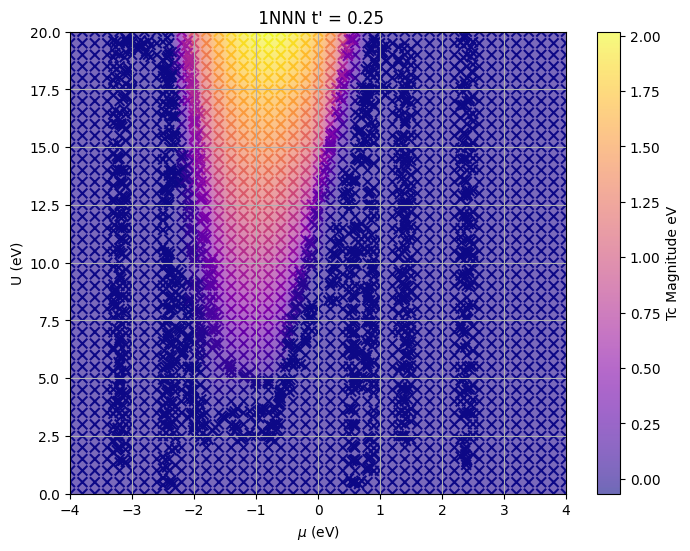

In [28]:
plot_U_J_Tc("1NNN_0p25_20_5_ff4_PhaseDiagram.log"," 1NNN t' = 0.25")

/tmp/ipykernel_6124/2554616597.py:38: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  scatter = ax.scatter(x, y, c=z, cmap='plasma', s=50, marker="x", edgecolors='k')


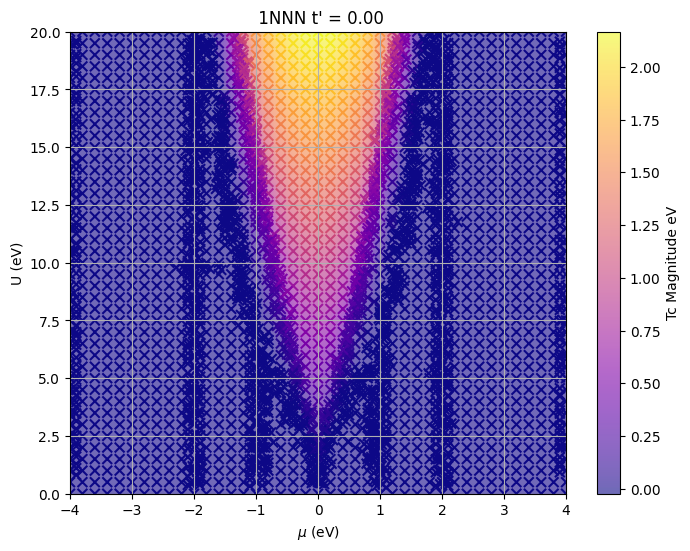

In [29]:
plot_U_J_Tc("1NN_20_5_ff4_PhaseDiagram.log"," 1NNN t' = 0.00")

In [32]:
def read_data(file_name):
    """Reads and processes data from a given file, correctly handling filenames with 'ffX'."""
    data = []
    
    with open(file_name, 'r') as f:
        for line in f:
            l = line.split()
            
            if len(l) != 4:
                continue  # Skip lines that do not match expected format
            
            try:
                # Extract the filename and split into parts
                file_parts = l[0].split("/")[-1].split("_")

                # Remove any "ffX" component
                file_parts = [part for part in file_parts if not (part.startswith("ff") and part[2:].isdigit())]

                # Extract only the LAST 4 elements (since the earlier ones are not needed)
                U = float(file_parts[-4])   # Extracts U parameter
                J = float(file_parts[-3])   # Extracts J parameter
                nk = int(file_parts[-2])    # Extracts nk number points
                nkf = int(file_parts[-1].split(".")[0])  # Extracts nkf number points

                Tc = l[1]  # Tc value
                phase = float(l[2])  # Dominant phase
                
                # Extract time in seconds
                time_parts = l[3].split("m")
                seconds = float(time_parts[0]) * 60 + float(time_parts[1].split("s")[0])
                
                # Store data as a LIST (not dictionary)
                final_data = [U, J, nk, nkf, Tc, phase, seconds]
                data.append(final_data)
            
            except (ValueError, IndexError) as e:
                print(f"Skipping line due to error: {line.strip()} - {e}")
    
    return data



In [84]:
import matplotlib.patches as mpatches
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from scipy.spatial import Voronoi, voronoi_plot_2d
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import matplotlib.colors as mcolors
from scipy.interpolate import griddata

def plot_U_J_Tc(filenames, models):
    fig, axes = plt.subplots(1, 4, figsize=(20, 6), constrained_layout=True)
    
    for idx, (inputname, model) in enumerate(zip(filenames, models)):
        data = read_data(inputname)
        
        x, y, points, z = [], [], [], []
        for d in data:
            y.append(d[0])  # U values (should be on y-axis)
            x.append(d[1])  # J values (should be on x-axis)
            points.append([d[1], d[0]])  # J, U vector
            z.append(d[5])  # Stores Tc
        
        max_U, min_U = max(y), min(y)
        max_J, min_J = max(x), min(x)
        
        # Generate grid for interpolation
        grid_x, grid_y = np.mgrid[min_J:max_J:200j, min_U:max_U:200j]
        grid_z = griddata((x, y), z, (grid_x, grid_y), method='cubic')
        
        ax = axes[idx]
        
        # Plot interpolated background
        contour = ax.contourf(grid_x, grid_y, grid_z, levels=100, cmap='plasma', alpha=0.6)
        
        # Scatter plot with colormap based on Tc magnitude
        scatter = ax.scatter(x, y, c=z, cmap='plasma', s=50, marker="x", edgecolors='k')
        
        # Compute Voronoi diagram
        points = np.array(points)
        vor = Voronoi(points)
        
        
        ax.set_xlabel(r"$\mu$(eV)", fontsize = 20)
        if idx == 0:
            ax.set_ylabel("U (eV)", fontsize =20 )
        ax.set_title(f"{model}", fontsize= 20)
        ax.grid(True, linestyle='--', linewidth=0.5)
        ax.tick_params("both", labelsize =18)
    
    # Add a single colorbar for all subplots
    cbar = fig.colorbar(scatter, ax=axes.ravel().tolist(), orientation='vertical', shrink=0.8, aspect=30)
    cbar.set_label("Tc Magnitude (eV)", fontsize = 20)
    cbar.ax.tick_params(labelsize=16)
    
    plt.savefig("combined_models.png")
    plt.show()


/tmp/ipykernel_6124/2205775888.py:38: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  scatter = ax.scatter(x, y, c=z, cmap='plasma', s=50, marker="x", edgecolors='k')


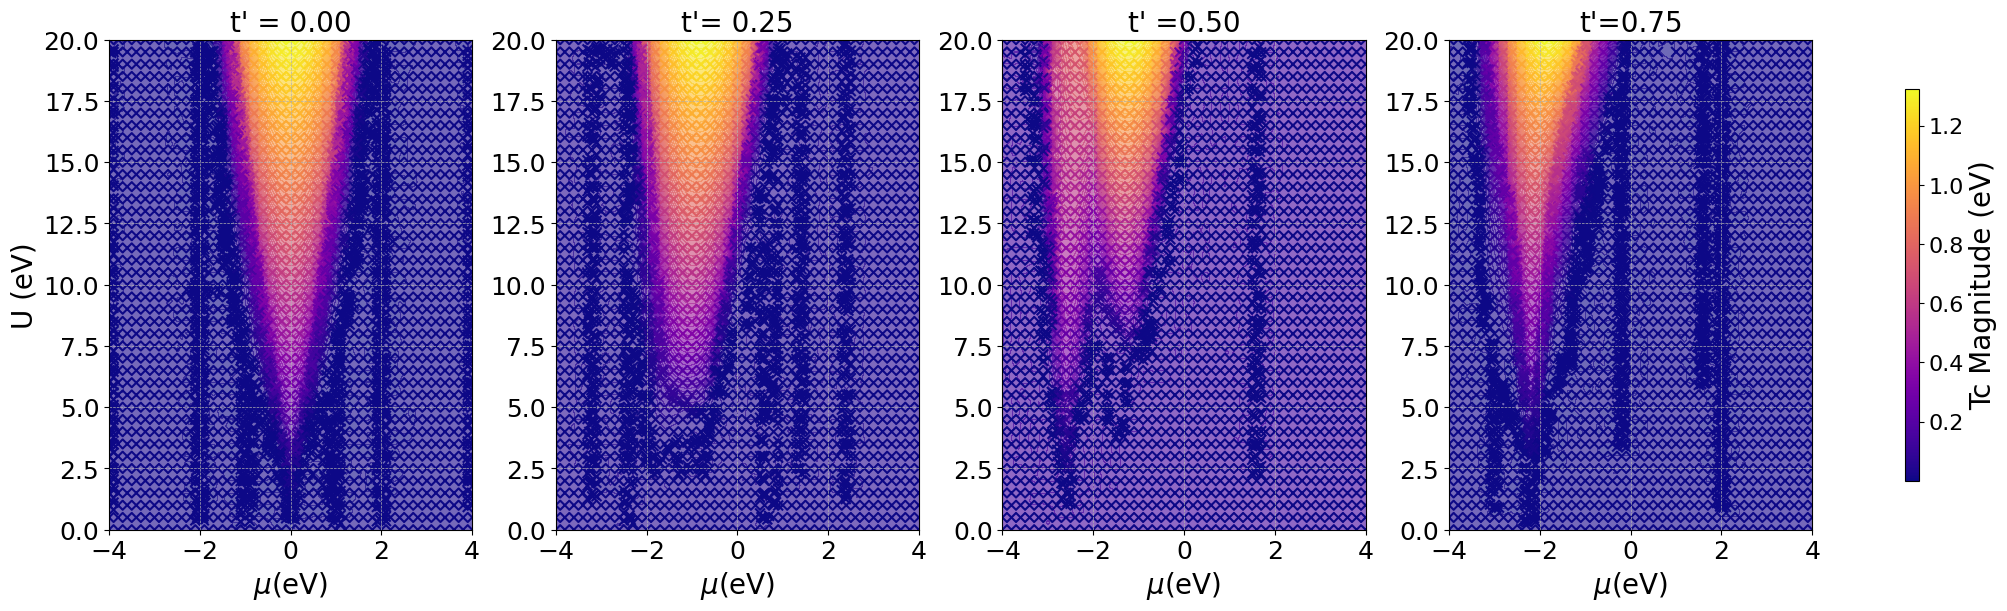

In [85]:
inputnames = ["1NN_20_5_ff4_PhaseDiagram.log", "1NNN_0p25_20_5_ff4_PhaseDiagram.log", "1NNN_0p5_20_5_ff4_PhaseDiagram.log","1NNN_0p75_20_5_ff4_PhaseDiagram.log"]
models =["t' = 0.00", "t'= 0.25", "t' =0.50", "t'=0.75"]

plot_U_J_Tc(inputnames, models)

In [86]:
import matplotlib.patches as mpatches
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from scipy.spatial import Voronoi, voronoi_plot_2d
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import matplotlib.colors as mcolors
from scipy.interpolate import griddata

def plot_U_J_Tc(filenames, models):
    fig, axes = plt.subplots(1, 4, figsize=(20, 6), constrained_layout=True)
    
    for idx, (inputname, model) in enumerate(zip(filenames, models)):
        data = read_data(inputname)
        
        x, y, points, z = [], [], [], []
        for d in data:
            if d[4] == "SC":  # Only include superconducting points
                y.append(d[0])  # U values (should be on y-axis)
                x.append(d[1])  # J values (should be on x-axis)
                points.append([d[1], d[0]])  # J, U vector
                z.append(d[5])  # Stores Tc
        
        if not x:  # Skip if no superconducting points
            continue
        
        max_U, min_U = max(y), min(y)
        max_J, min_J = max(x), min(x)
        
        # Generate grid for interpolation
        grid_x, grid_y = np.mgrid[min_J:max_J:200j, min_U:max_U:200j]
        grid_z = griddata((x, y), z, (grid_x, grid_y), method='cubic')
        
        ax = axes[idx]
        
        # Plot interpolated background
        #contour = ax.contourf(grid_x, grid_y, grid_z, levels=100, cmap='plasma', alpha=0.6)
        
        # Scatter plot with colormap based on Tc magnitude
        scatter = ax.scatter(x, y, c=z, cmap='plasma', s=50, marker="x", edgecolors='k')
        
        # Compute Voronoi diagram
        points = np.array(points)
        vor = Voronoi(points)
        
        
        
        ax.set_xlabel(r"$\mu$ (eV)", fontsize = 18)
        if idx == 0:
            ax.set_ylabel("U (eV)", fontsize =18)

        ax.grid(True, linestyle='--', linewidth=0.5)
        ax.tick_params("both", labelsize =18)
    
    # Add a single colorbar for all subplots
    cbar = fig.colorbar(scatter, ax=axes.ravel().tolist(), orientation='vertical', shrink=0.8, aspect=30)
    cbar.set_label("Tc Magnitude (eV)", fontsize = 18)
    cbar.ax.tick_params(labelsize=16)
    
    plt.savefig("combined_SC_models.png")
    plt.show()

/tmp/ipykernel_6124/4288505252.py:42: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  scatter = ax.scatter(x, y, c=z, cmap='plasma', s=50, marker="x", edgecolors='k')


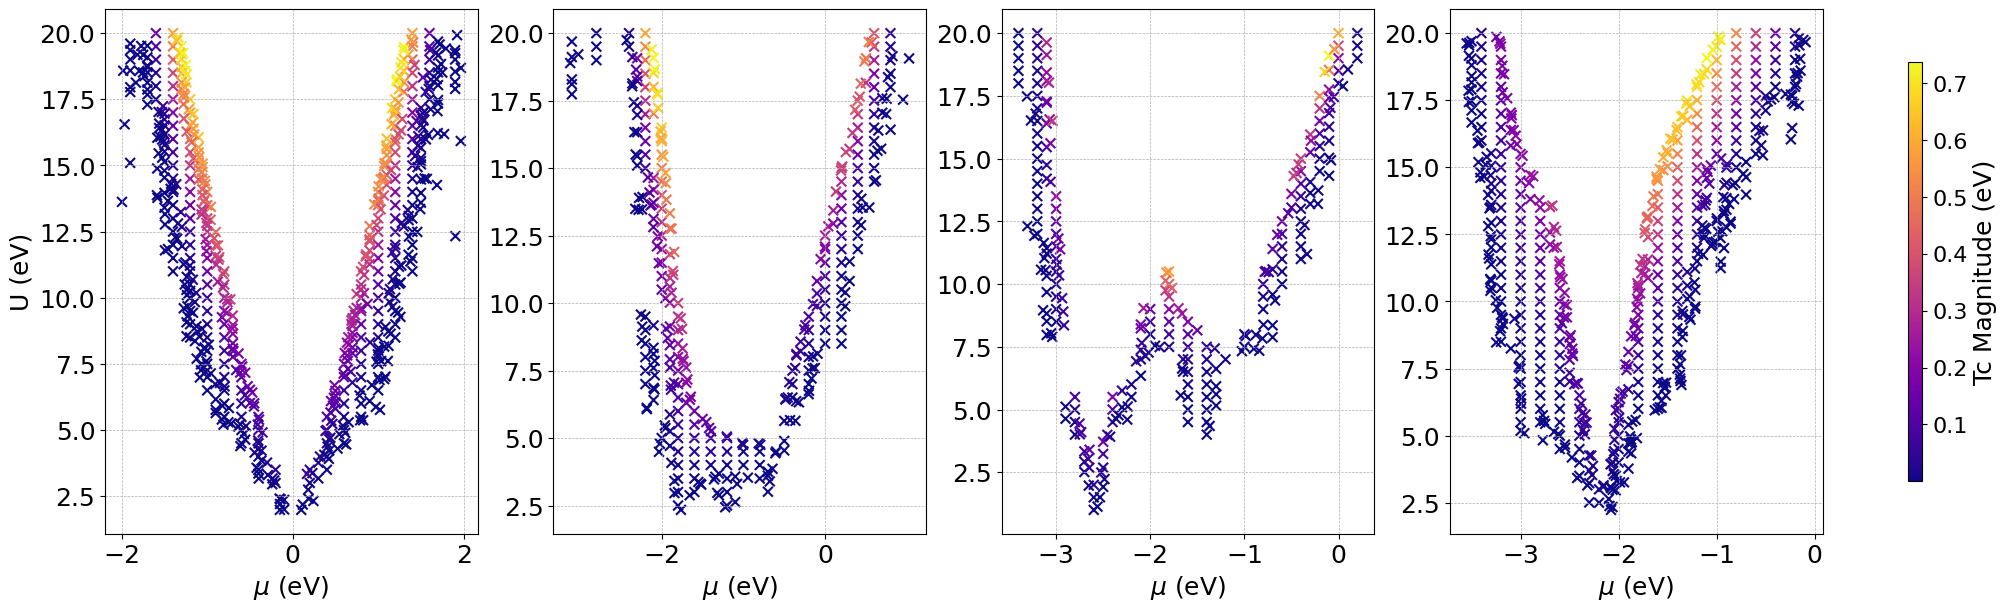

In [87]:
inputnames = ["1NN_20_5_ff4_PhaseDiagram.log", "1NNN_0p25_20_5_ff4_PhaseDiagram.log", "1NNN_0p5_20_5_ff4_PhaseDiagram.log","1NNN_0p75_20_5_ff4_PhaseDiagram.log"]
models =["t' = 0.00", "t'= 0.25", "t' =0.50", "t'=0.75"]

plot_U_J_Tc(inputnames, models)
